# Clasificación con diferentes modelos CNN

En el presente notebook, se validarán diferentes arquitecturas de modelos CNN para clasificar imágenes del dataset Retail Product Checkout Dataset (RPC). Se pretende clasificar las 17 super categorías de dicho dataset y evaluar la precisión de las predicciones realizadas por los modelos respecto a las super categorías originales.

## Contenido

####  1. Importación de librerías y cargue del dataset RPC
####  2. Definición de las funciones para mostrar los resultados
####  3. Clasificación con el modelo CNN Test (U3.2.1)
####  4. Clasificación con el modelo Transfer Learning InceptionV3 (U3.2.2)
####  5. Clasificación con el modelo CNN Test con Validación (U3.2.3)

## 1. Importación de librerías y cargue del dataset RPC 

Inicialmente, se importan las librerías que serán requeridas a lo largo del proceso.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from __future__ import division
%matplotlib inline

Se lee el archivo json que contiene información del dataset y se dividen en datasets de imágenes y etiquetas.

In [2]:
data_df = pd.read_json('./data/instances_train2019.json', lines=True)
categories = data_df['categories'][0]
categories = df = pd.DataFrame.from_dict(categories, orient='columns')
annotations = data_df['annotations'][0]
annotations = df = pd.DataFrame.from_dict(annotations, orient='columns')
images = data_df['images'][0]
images = df = pd.DataFrame.from_dict(images, orient='columns')

annot_x_categ = pd.merge(annotations, categories, how='left', left_on=['category_id'], right_on=['id'])
y_names = annot_x_categ['supercategory'].unique().tolist()
annot_x_categ_file_names = pd.merge(annot_x_categ, images, how='left', left_on=['image_id'], right_on=['id'])
y_data = np.array(annot_x_categ_file_names['supercategory'].values)
X_data = np.array(annot_x_categ_file_names['file_name'].values)
num_classes = len(y_names)

print X_data.shape, y_data.shape, num_classes

(53739,) (53739,) 17


Se divide el conjunto de datos entre train y test.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42991,), (10748,), (42991,), (10748,))

Se crea un dataframe con el conjunto de datos de test.

In [4]:
columns = ['filename','class']

df_test = pd.DataFrame(columns=columns)
df_test['filename'] = X_test.astype(str)
df_test['class'] = y_test.astype(str)

Luego de esto, se utiliza $\textbf{ImageDataGenerator}$ para normalizar las imágenes y definir un tamaño de batch para realizar las predicciones con los datos de test.

In [5]:
test_datagen=ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 50
img_size = 200

test_generator_fn = lambda: test_datagen.flow_from_dataframe(
        df_test,  
        directory="./data/train2019/", 
        x_col='filename', 
        y_col='class',
        target_size=(img_size, img_size),  
        batch_size=batch_size,
        interpolation = 'nearest',
        class_mode='categorical') 

## 2. Definición de las funciones para mostrar los resultados

Se define la función predict, la cual realiza las predicciones del modelo. Devuelve las etiquetas reales junto con las predicciones.

In [6]:
def predict(model, imgs_test, labels_test):
    Nlab = np.where(labels_test==1)[1]
    y_test_id=[]
    for i in range(imgs_test.shape[0]):
        y_test_id.append(Nlab[i])
    y_test_id = np.array(y_test_id)
    
    preds = model.predict(imgs_test)
    preds = np.argmax(preds, axis=-1)
    
    return y_test_id, preds

Se define la función show_predict, que muestra las imágenes de las predicciones.

In [7]:
def show_predict(imgs_test, y_test_id, preds, y_names):
    fig = plt.figure(figsize=(20,batch_size))
    for i in range(imgs_test.shape[0]):
        ax=fig.add_subplot(imgs_test.shape[0]/5,5,i+1)
        plt.imshow(imgs_test[i], interpolation="nearest")
        plt.subplots_adjust(hspace=0.5)    
        ax.set_xlabel('label / prediction')
        ax.set_title(y_names[y_test_id[i]] + ' / ' +y_names[preds[i]])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

Se define la función show_confusion_matrix, que muestra la matriz de confusión de las etiquetas respecto a las prediciones de las imágenes.

In [8]:
def show_confusion_matrix(y_test_id, preds, num_classes, y_names, title):
    fig = plt.figure(figsize=(20,10))
    cm = confusion_matrix(y_test_id, preds)
    cm = cm/np.sum(cm)
    cmap = plt.cm.Blues
    tick_marks = np.arange(num_classes)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, y_names, rotation=45)
    plt.yticks(tick_marks, y_names)

## 3. Clasificación con el modelo CNN Test (U3.2.1)

Se crea la carpeta "models" en el directorio raíz.

In [9]:
model_dir = './models/'
tf.gfile.MakeDirs(model_dir)

Descargamos el modelo CNN_Test, el cual fue entrenado en el notebook "U3.2.1 - Modelo CNN". Este fue entrenado sin datos de validación como una prueba previa.

In [10]:
!wget -P './models/' -nc https://www.dropbox.com/s/dkwrodqg3dn31cn/CNN_Test.model

File ‘./models/CNN_Test.model’ already there; not retrieving.



Cargamos el modelo CNN_Test y mostramos su arquitectura.

In [11]:
from tensorflow.keras.models import load_model

model = load_model(model_dir+"CNN_Test.model")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 100)     24400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 50)        125050    
_________________________________________________________________
dropout (Dropout)            (None, 92, 92, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 25)        11275     
__________

Se genera un conjunto aleatorio de test de acuerdo al tamaño batch del test generator.

In [12]:
for imgs_test,labels_test in test_generator_fn():
    if np.random.random()>.7:
        break

Found 10748 validated image filenames belonging to 17 classes.


Obtenemos las etiquetas y las predicciones del modelo.

In [13]:
y_test_id, preds = predict(model, imgs_test, labels_test)
y_test_id, preds

(array([ 0,  9,  7, 16,  4, 16,  9,  4,  6, 12, 15,  4,  4,  9,  2,  9,  9,
        14,  6, 15, 13,  7, 11,  1, 16,  5, 13,  4,  5,  3, 15, 16, 16,  4,
         5, 16,  6,  4, 13, 10, 15, 16,  7, 15, 10, 16, 10,  4,  3,  2]),
 array([12,  9,  7, 16,  4, 16,  9,  1,  6,  3, 15,  4,  4,  5,  0,  9,  9,
         1,  5, 15, 13,  0,  7,  8, 16,  6,  6,  4,  5,  3, 15, 16,  4,  4,
         6, 16,  6,  4, 13,  9, 15, 16,  7, 16, 13, 16, 10,  4,  3,  2]))

En la siguiente celda, ejecutamos la función que muestra las imágenes obtenidas por el batch, con sus respetivas etiquetas y predicciones.

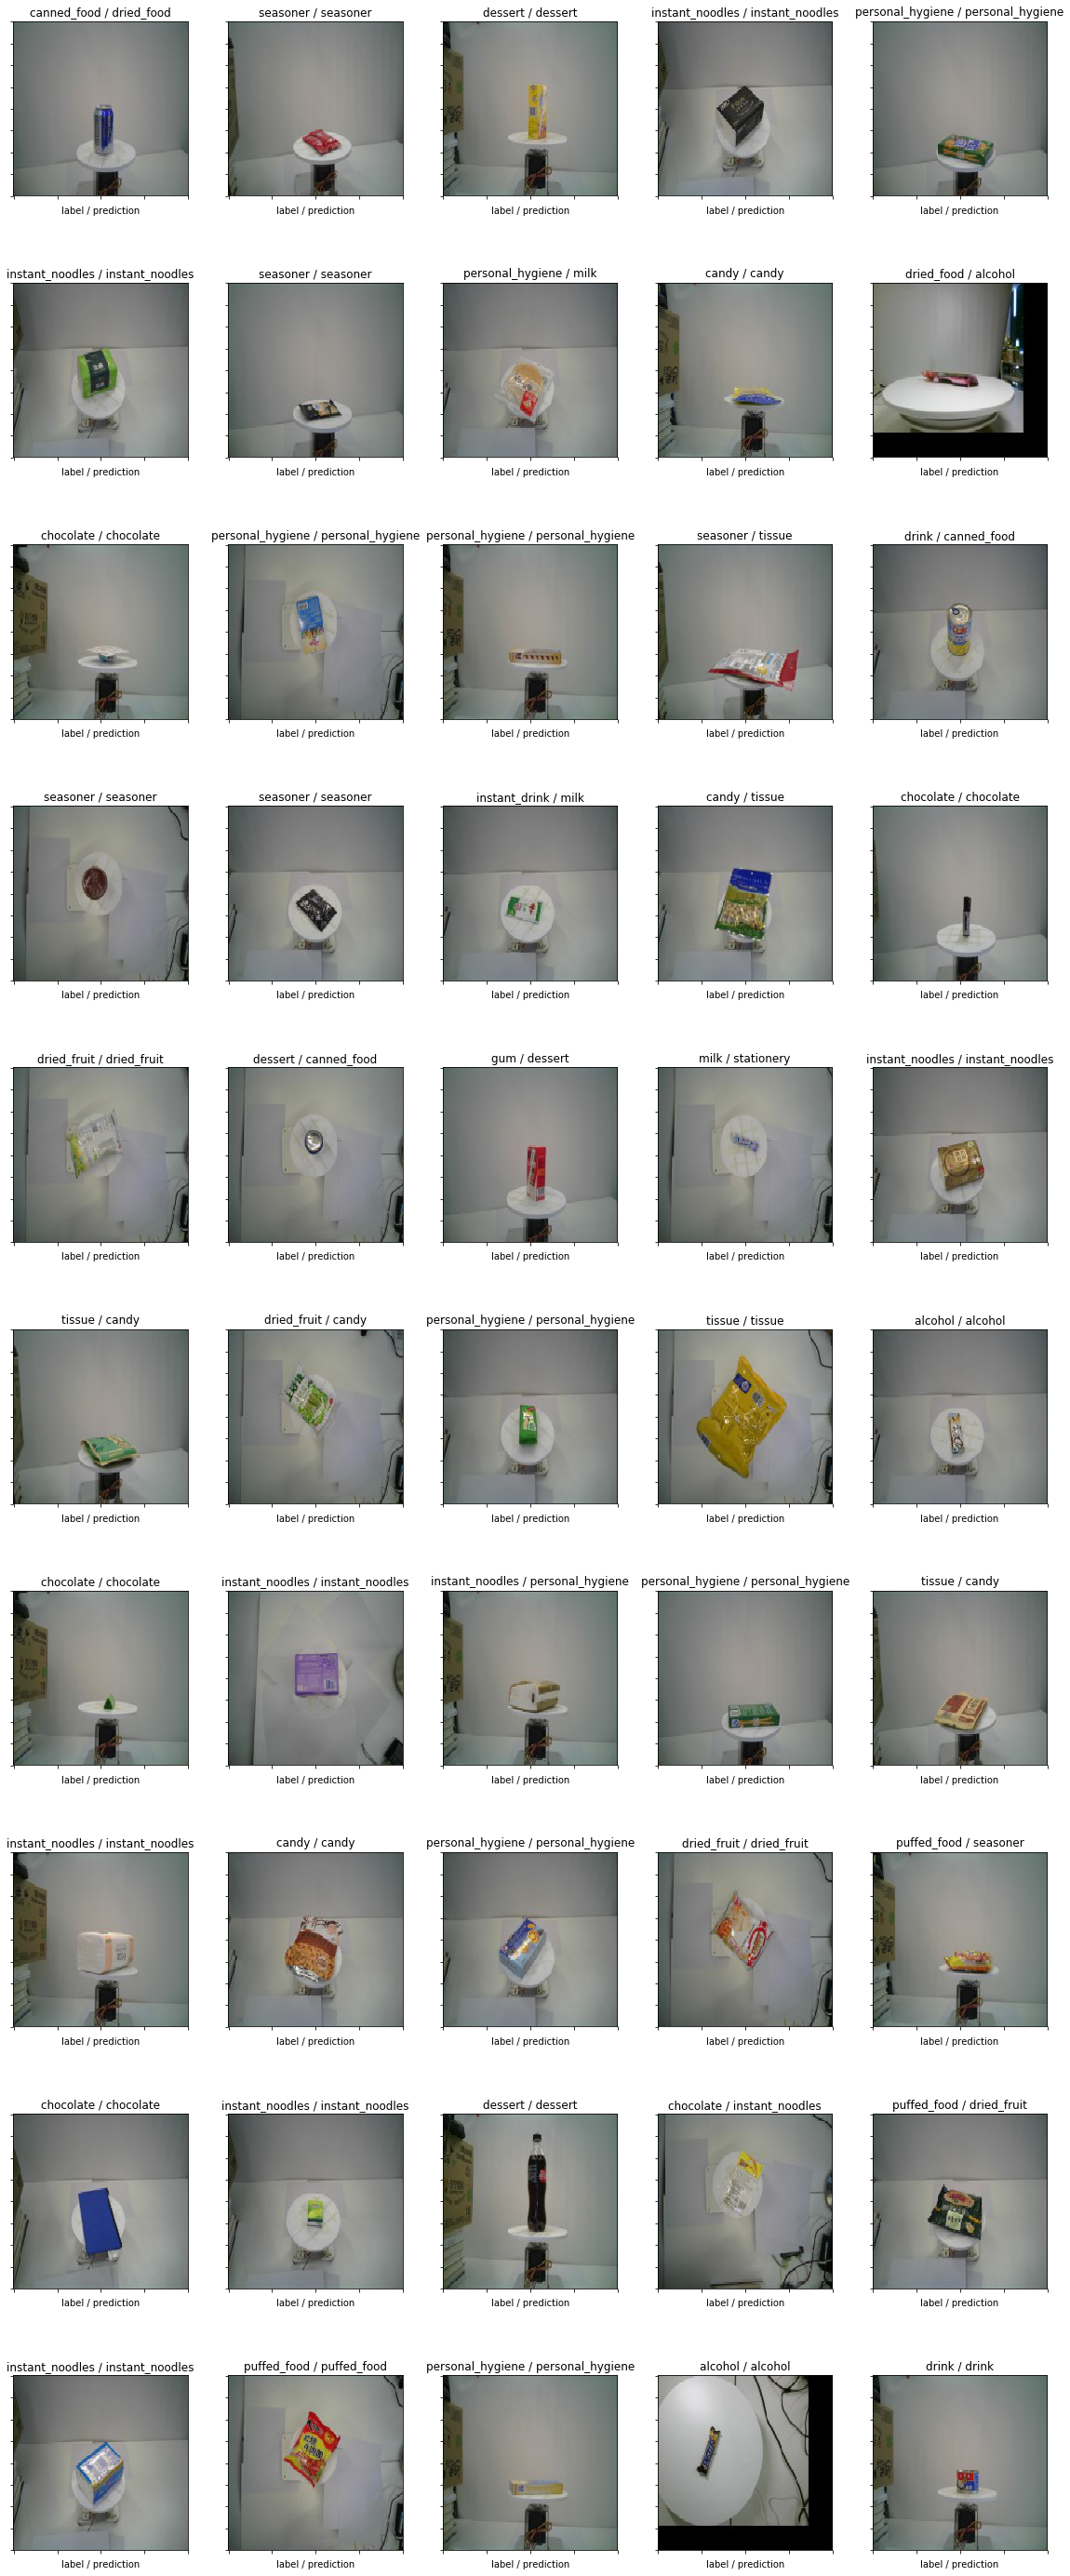

In [14]:
show_predict(imgs_test, y_test_id, preds, y_names)

Se calcula el porcentaje de accuracy de las predicciones respecto a las etiquetas originales.

In [15]:
accuracy = np.mean(preds == y_test_id)
print 'Accuracy = ', accuracy*100, '%'

Accuracy =  66.0 %


El modelo nos muestra un buen accuracy si se tiene en cuenta que fue entrenado sin datos de validación.

A continuación, mostramos la matriz de confusión de las predicciones respecto a las etiquetas originales.

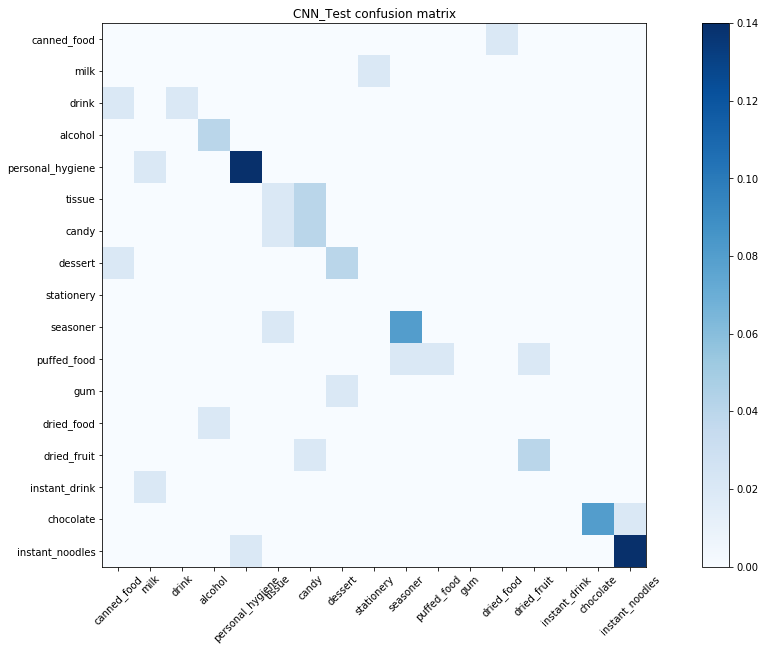

In [16]:
show_confusion_matrix(y_test_id, preds, num_classes, y_names, 'CNN_Test confusion matrix')

A pesar de que el accuracy no es tan bajo, en varias super categorías se obtienen predicciones dispersas, es decir, que no se encuentran sobre la diagonal. Esto, nos muestra que hace falta un entrenamiento con datos de validación para nuestro modelo.

## 4. Clasificación con el modelo Transfer Learning InceptionV3 (U3.2.2)

Descargamos el modelo Transfer_Learning_InceptionV3, el cual fue entrenado en el notebook "U3.2.2 - Modelo CNN - Transfer Learning Inception V3".

In [29]:
!wget -P './models/' -nc https://www.dropbox.com/s/bh12u0rm6nml05g/Transfer_Learning_InceptionV3.model

File ‘./models/Transfer_Learning_InceptionV3.model’ already there; not retrieving.



Cargamos el modelo Transfer_Learning_InceptionV3 y mostramos su arquitectura.

In [31]:
from tensorflow.keras.models import load_model

model3 = load_model(model_dir+"Transfer_Learning_InceptionV3.model")
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Obtenemos las etiquetas y las predicciones del modelo.

In [33]:
y_test_id, preds = predict(model3, imgs_test, labels_test)
y_test_id, preds

(array([ 0,  9,  7, 16,  4, 16,  9,  4,  6, 12, 15,  4,  4,  9,  2,  9,  9,
        14,  6, 15, 13,  7, 11,  1, 16,  5, 13,  4,  5,  3, 15, 16, 16,  4,
         5, 16,  6,  4, 13, 10, 15, 16,  7, 15, 10, 16, 10,  4,  3,  2]),
 array([ 7,  1, 11, 16,  4, 16, 16,  9,  3,  3, 16, 15,  2, 15,  0,  9,  9,
        11, 15, 15, 13,  3, 11,  3,  4, 16,  6,  2,  6,  3, 16, 16, 16, 16,
        16, 16, 10,  4, 13,  4, 15, 16,  7, 15, 15, 16, 13,  4,  3,  4]))

En la siguiente celda, ejecutamos la función que muestra las imágenes obtenidas por el batch, con sus respetivas etiquetas y predicciones.

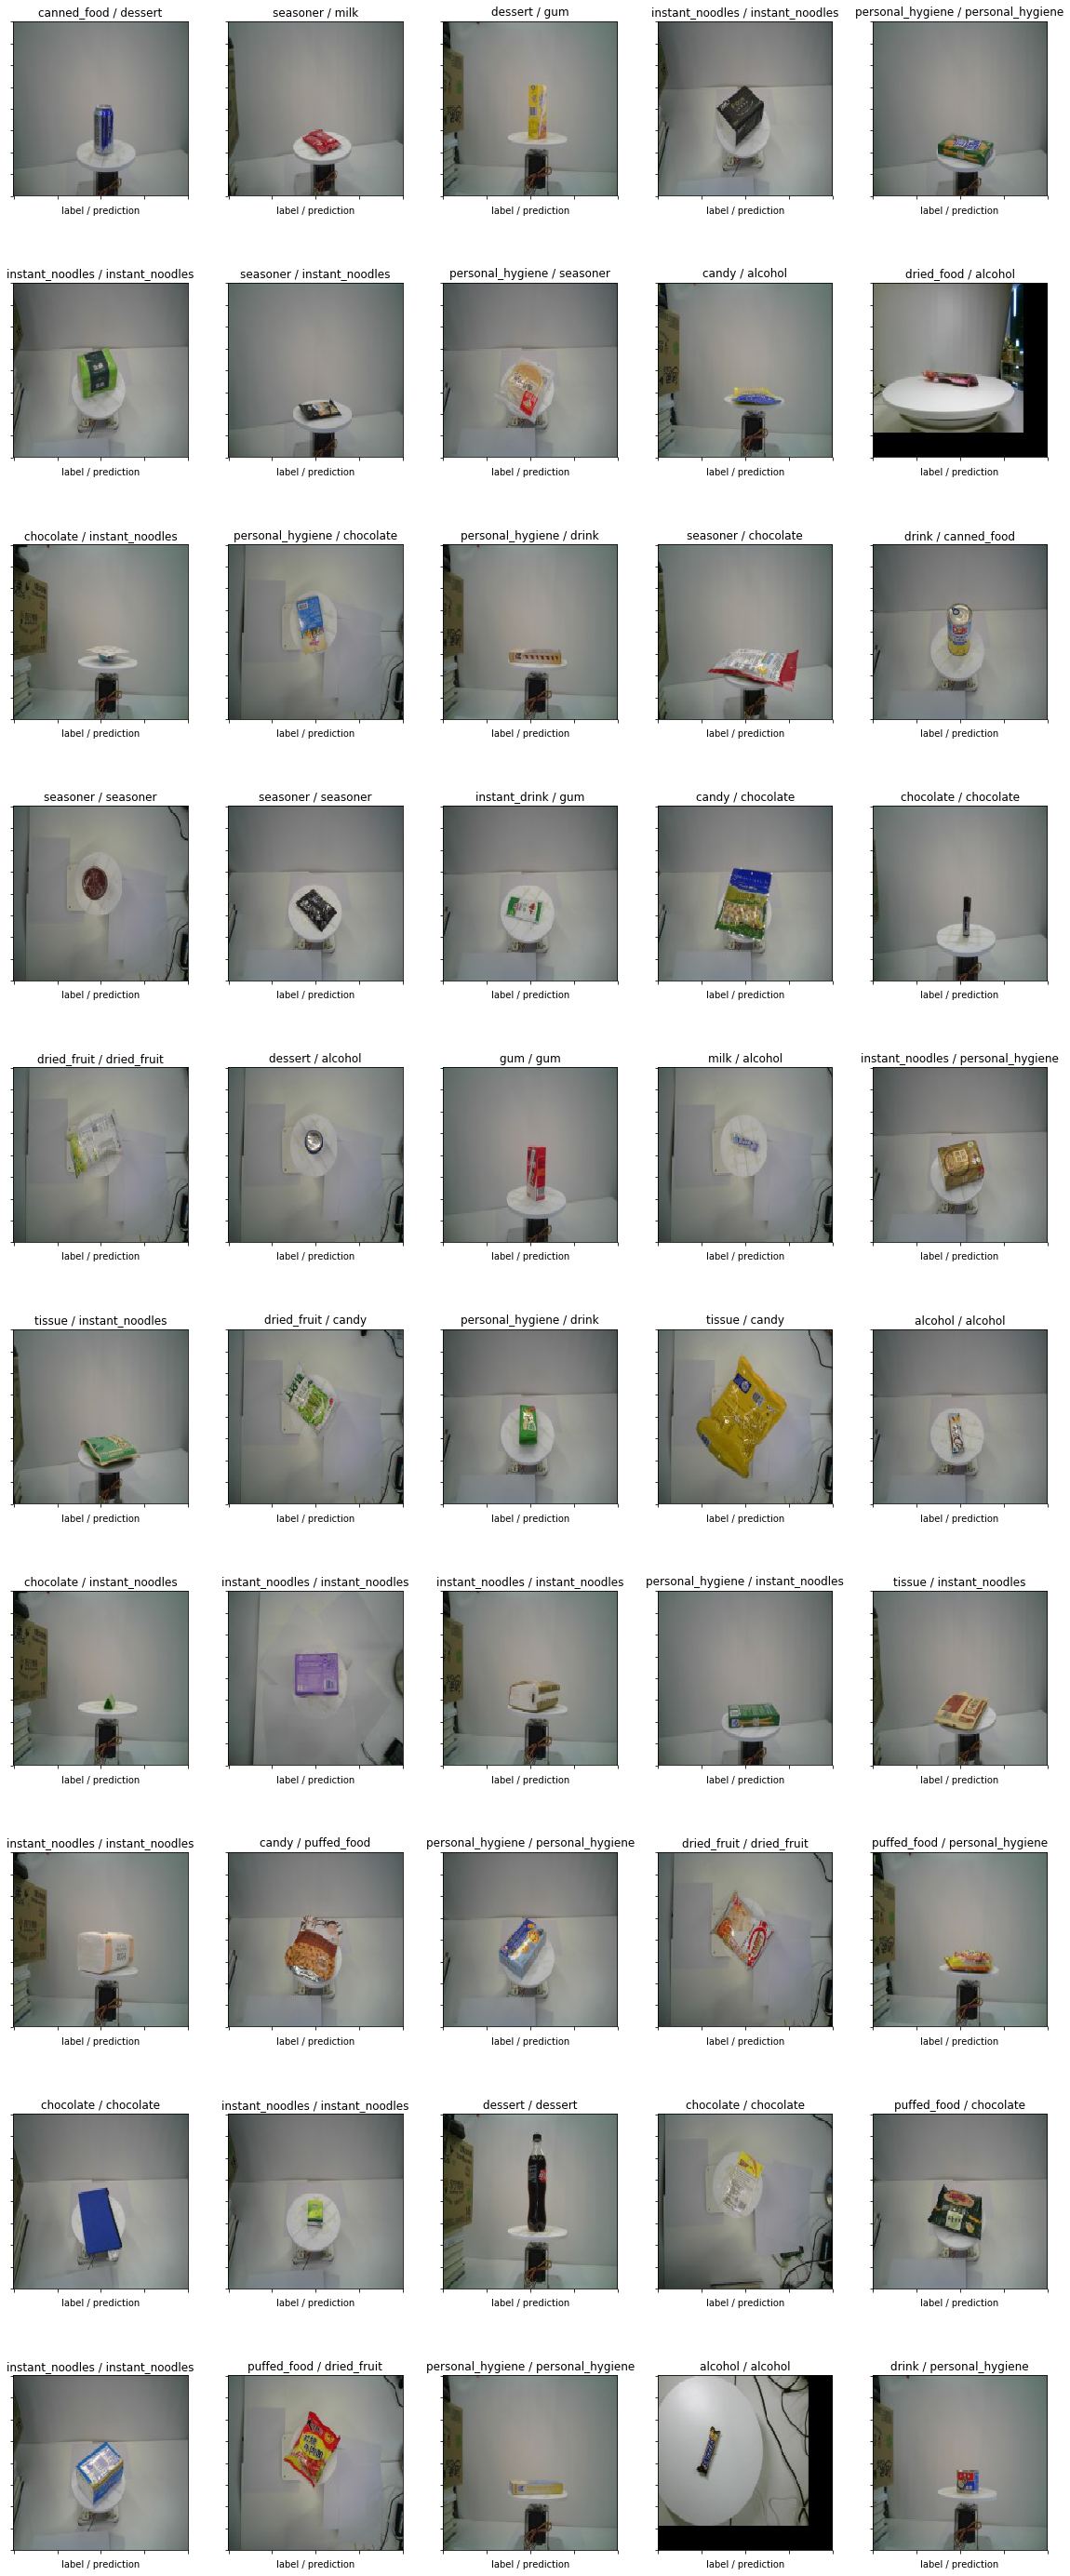

In [35]:
show_predict(imgs_test, y_test_id, preds, y_names)

Se calcula el porcentaje de accuracy de las predicciones respecto a las etiquetas originales.

In [36]:
accuracy = np.mean(preds == y_test_id)
print 'Accuracy = ', accuracy*100, '%'

Accuracy =  42.0 %


El modelo nos muestra un accuracy inferior al 50%, lo cual indica que se equivoca en más de la mitad predicciones.  Esto es debido a que en el entramiento del modelo realizado en el notebook "U3.2.3 - Modelo CNN - Transfer Learning Inception V3", se obtuvo una gran diferencia del accuracy entre train y validation, como se puede observar en la siguiente imagen: ![alt text](./images/Train_Transfer_Learning_InceptionV3.PNG)
 
A pesar de que el train obtiene un valor alto de accuracy, vemos que existe overfitting en nuestro modelo, lo cual no nos permite realizar predicciones correctas. 

A continuación, mostramos la matriz de confusión de las predicciones respecto a las etiquetas originales.

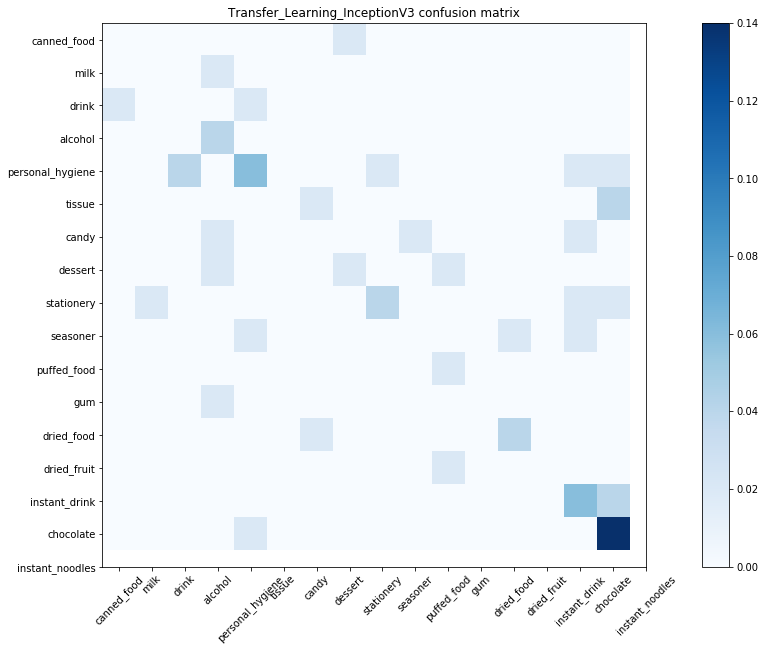

In [37]:
show_confusion_matrix(y_test_id, preds, num_classes, y_names, 'Transfer_Learning_InceptionV3 confusion matrix')

En este caso, se observa que en muchas super categorías se obtienen predicciones dispersas, es decir, que no se encuentran sobre la diagonal. Esto evidencia que el modelo requiere que no exista overffiting para tener una mayor precisión a la hora de predecir.

## 5. Clasificación con el modelo CNN Test con Validación (U3.2.3)

Descargamos el modelo CNN_Test_Val, el cual fue entrenado en el notebook "U3.2.3 - Modelo CNN con Validación".

In [19]:
!wget -P './models/' -nc https://www.dropbox.com/s/ude885e0nesffwg/CNN_Test_Val.model

--2019-04-18 12:48:55--  https://www.dropbox.com/s/ude885e0nesffwg/CNN_Test_Val.model
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ude885e0nesffwg/CNN_Test_Val.model [following]
--2019-04-18 12:48:55--  https://www.dropbox.com/s/raw/ude885e0nesffwg/CNN_Test_Val.model
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdabf9ca1d3873518c31c41ab1.dl.dropboxusercontent.com/cd/0/inline/AfQ76c92E6QLSpaKrHTocFmvXsUHAnMGxbsrC907jYRr5Vcg0t2C-WxnPQ_VTn58du4OIhBYGlgZ1ng8N3wsZwze3510ZB6pxLaTvsQnGWsnJXfPtEtHhf3Zi3pHZqKy9PI/file# [following]
--2019-04-18 12:48:56--  https://uccdabf9ca1d3873518c31c41ab1.dl.dropboxusercontent.com/cd/0/inline/AfQ76c92E6QLSpaKrHTocFmvXsUHAnMGxbsrC907jYRr5Vcg0t2C-WxnPQ_VTn58du4OIhBYGlgZ1ng8N3wsZwze3510ZB6p

Cargamos el modelo CNN_Test_Val, haciendo uso de las clases $\textbf{CustomObjectScope}$ y $\textbf{glorot_uniform}$ de keras, debido a que el modelo fue entrenado en la plataforma Colab de Google y el archivo con extensión .model tiene otro formato.
Luego, mostramos la arquitectura del modelo.

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform 

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model2 = load_model(model_dir+"CNN_Test_Val.model")
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 100)     24400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 50)        125050    
_________________________________________________________________
dropout (Dropout)            (None, 92, 92, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 25)        11275     
__________

Obtenemos las etiquetas y las predicciones del modelo.

In [23]:
y_test_id, preds = predict(model2, imgs_test, labels_test)
y_test_id, preds

(array([ 0,  9,  7, 16,  4, 16,  9,  4,  6, 12, 15,  4,  4,  9,  2,  9,  9,
        14,  6, 15, 13,  7, 11,  1, 16,  5, 13,  4,  5,  3, 15, 16, 16,  4,
         5, 16,  6,  4, 13, 10, 15, 16,  7, 15, 10, 16, 10,  4,  3,  2]),
 array([ 0,  9,  7, 16,  4, 16,  9,  4,  6, 12, 15,  4,  4,  5,  2,  9,  9,
        14,  6, 15, 13,  7, 11,  1, 16,  5, 13,  4,  5,  3, 15, 16, 16,  4,
         5, 16,  6,  4, 13, 10, 15, 16,  7, 15, 10, 16, 10,  4,  3,  2]))

En la siguiente celda, ejecutamos la función que muestra las imágenes obtenidas por el batch, con sus respetivas etiquetas y predicciones.

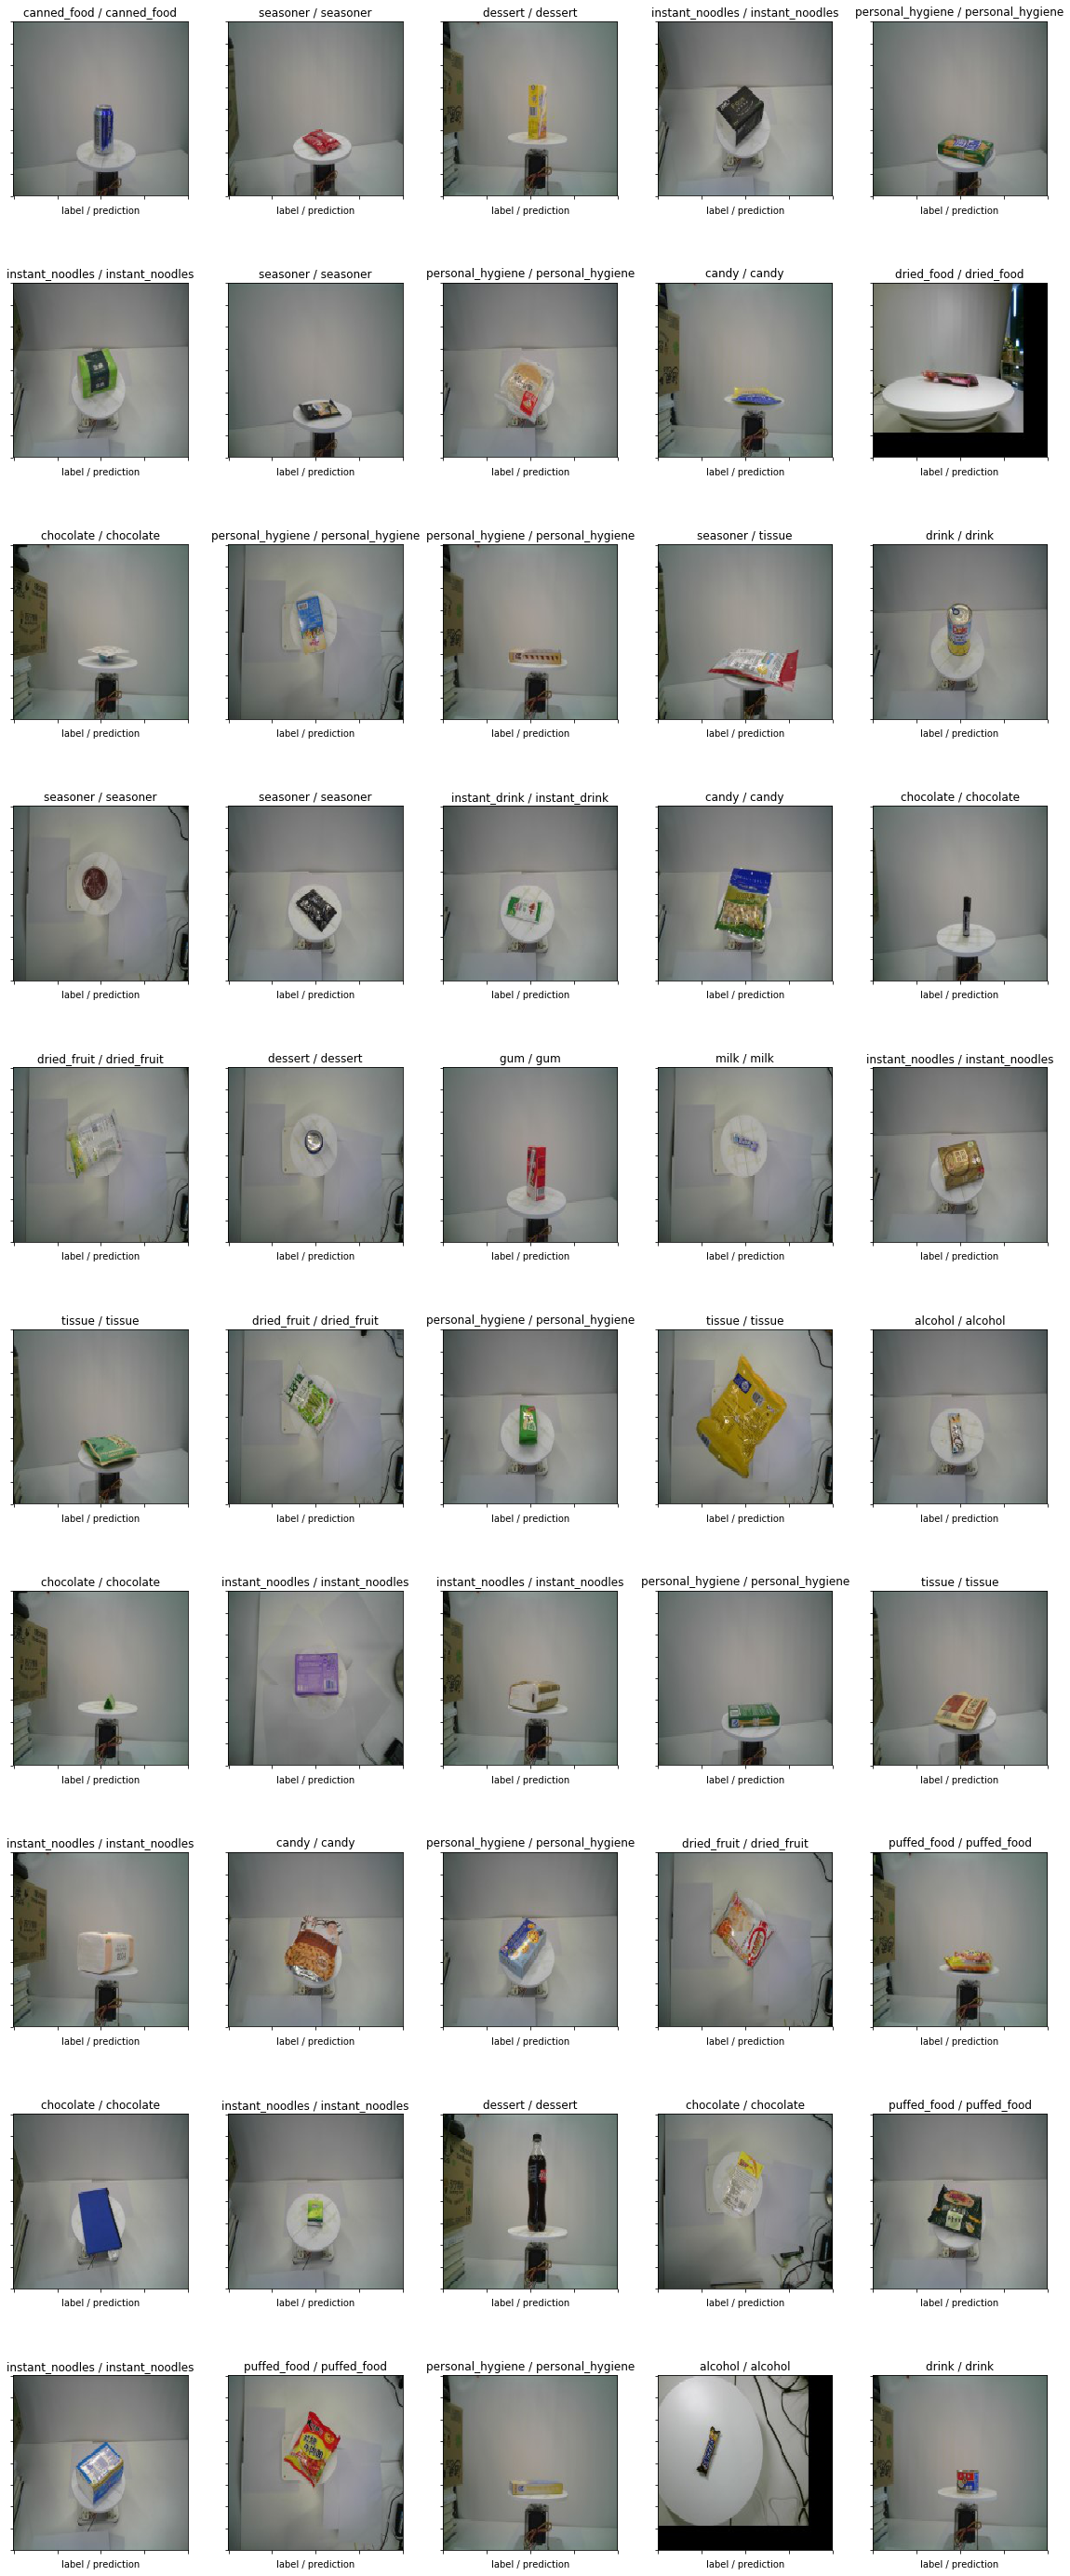

In [24]:
show_predict(imgs_test, y_test_id, preds, y_names)

Se calcula el porcentaje de accuracy de las predicciones respecto a las etiquetas originales.

In [25]:
accuracy = np.mean(preds == y_test_id)
print 'Accuracy = ', accuracy*100, '%'

Accuracy =  98.0 %


El modelo nos muestra un accuracy cercano al 100%, lo cual indica que en general no se equivoca en ninguna predicción. Esto es debido a la cercanía del accuracy entre train y validation obtenida cuando se entrenó el modelo en el notebook "U3.2.2 - Modelo CNN con Validación", donde ambos se acercaron al 100%, como se puede observar en la siguiente imagen: ![alt text](./images/Train_CNN_Test_Val.PNG)
 
Con esto podemos concluir que no existe overfitting en nuestro modelo. 

A continuación, mostramos la matriz de confusión de las predicciones respecto a las etiquetas originales.

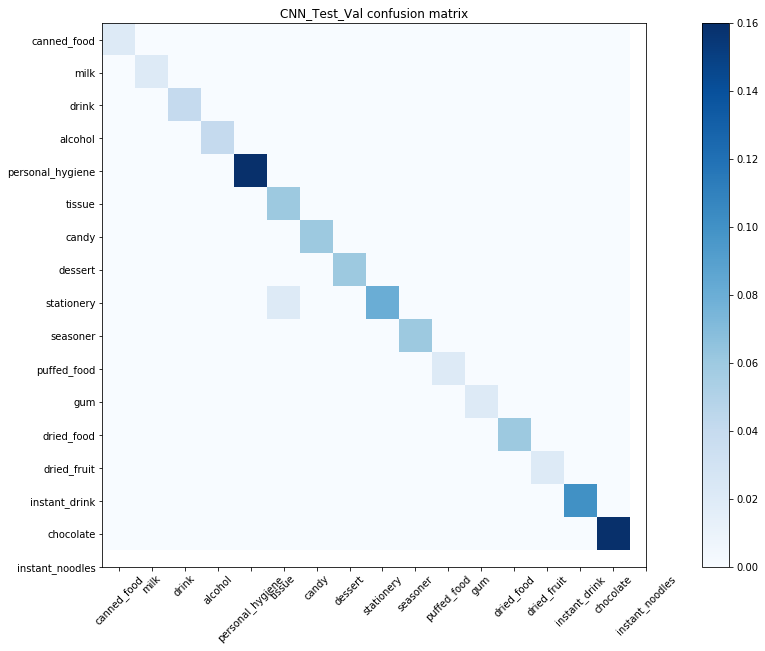

In [28]:
show_confusion_matrix(y_test_id, preds, num_classes, y_names, 'CNN_Test_Val confusion matrix')

Vemos como casi todas las predicciones se encuentra sobre la diagonal. Nuevamente, evidenciamos que el modelo está cercano al 100% de accuracy.